# Importing libraries and Preparing data

In [222]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,models
from torchvision import transforms as T
import torch.nn.functional as F
import cv2

# Ignore warnings
import warnings
torch.manual_seed(17)
warnings.filterwarnings("ignore")

root_dir="/kaggle/input/projet-deep-learning/train"


In [223]:
d=dict()
for filename in os.listdir(root_dir):
    id_img=int(filename.split("_")[0])
    if id_img in d.keys():
        d[id_img].append(filename)
    else:
        d[id_img]=[filename]

        

In [224]:
import random
random.seed(10)
train_l=[]
val_l=[]
keys_list=list(d.keys())
train_keys=keys_list[:len(keys_list)-100]
val_keys=keys_list[len(keys_list)-100:len(keys_list)]
for key in train_keys:
    kk=train_keys[:]
    kk.remove(key)
    for j in range(25):
        anchor_idx,pos_idx=random.sample( range(len(d[key])),2)
        neg_key=random.randint( 0,len(kk)-1 )
        neg_key=kk[neg_key]
        kk.remove(neg_key)
        neg_idx=random.randint(0 , len(d[neg_key])-1) 
        anchor,positive,negative=d[key][anchor_idx],d[key][pos_idx],d[neg_key][neg_idx]
        train_l.append((anchor,positive,1))
        train_l.append((anchor,negative,-1))
for key in val_keys:
    kk=val_keys[:]
    kk.remove(key)
    for j in range(25):
        anchor_idx,pos_idx=random.sample( range(len(d[key])),2)
        neg_key=random.randint( 0,len(kk)-1 )
        neg_key=kk[neg_key]
        kk.remove(neg_key)
        neg_idx=random.randint(0 , len(d[neg_key])-1) 
        anchor,positive,negative=d[key][anchor_idx],d[key][pos_idx],d[neg_key][neg_idx]
        val_l.append((anchor,positive,1))
        val_l.append((anchor,negative,-1))


In [225]:
train_l=list(set(train_l))
val_l=list(set(val_l))

In [226]:
query_list=[]
val_list=[]
d_truth=dict()
for key in val_keys:
  if(len(d[key]) >=5 ):
    query_val_ids = random.sample( range(len(d[key])) , 5)
    for ids in query_val_ids:
        if ids==query_val_ids[0]:
            query_list.append(d[key][ids])
            d_truth [ d[key][ids] ]=[]
        else:
            val_list.append(d[key][ids])
            d_truth [ d[key][query_val_ids[0]] ].append(d[key][ids])


# Creating the datasets

In [227]:
class MyDataset(Dataset):

    def __init__(self, l, root_dir, transform=None):

        self.l =l
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.l)

    def __getitem__(self, idx):
        anchor_path=os.path.join(self.root_dir, self.l[idx][0])
        comp_path=os.path.join(self.root_dir, self.l[idx][1])
        label= self.l[idx][2]
        anchor_img=cv2.imread(anchor_path)
        anchor_img=cv2.cvtColor(anchor_img, cv2.COLOR_BGR2RGB)
        comp_img=cv2.imread(comp_path)
        comp_img=cv2.cvtColor(comp_img, cv2.COLOR_BGR2RGB)

        if self.transform:
            anchor_img = self.transform(anchor_img)
            comp_img = self.transform(comp_img)
        return (anchor_img,comp_img,label)


In [228]:
class custom_val(Dataset):

    def __init__(self, l, root_dir, transform=None):
   
        self.l =l
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.l)

    def __getitem__(self, idx):
        img_path=os.path.join(self.root_dir,  self.l[idx])
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img

In [229]:
Train_data=MyDataset(train_l,root_dir)
validation_data=MyDataset(val_l,root_dir)

Showing some images from the train and validation data

<Figure size 640x480 with 0 Axes>

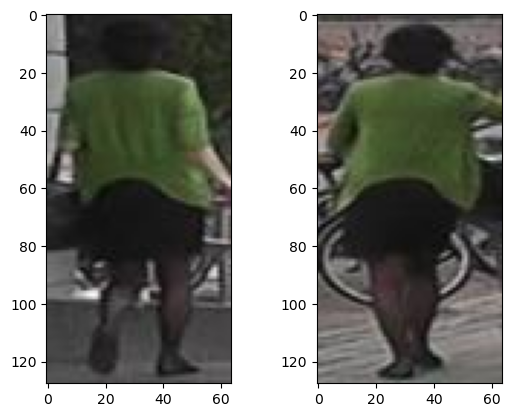

<Figure size 640x480 with 0 Axes>

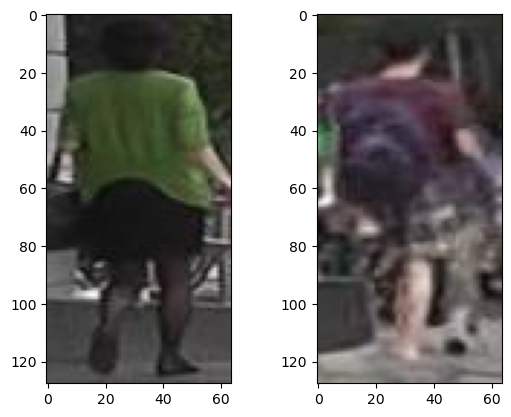

<Figure size 640x480 with 0 Axes>

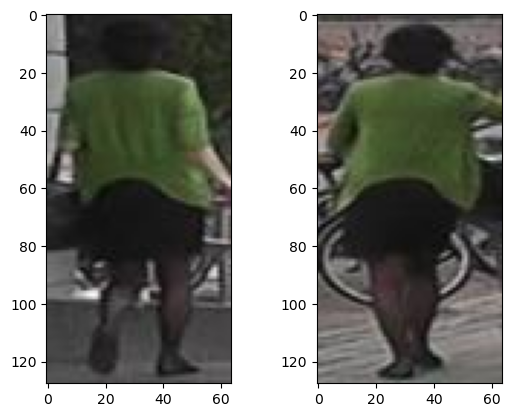

<Figure size 640x480 with 0 Axes>

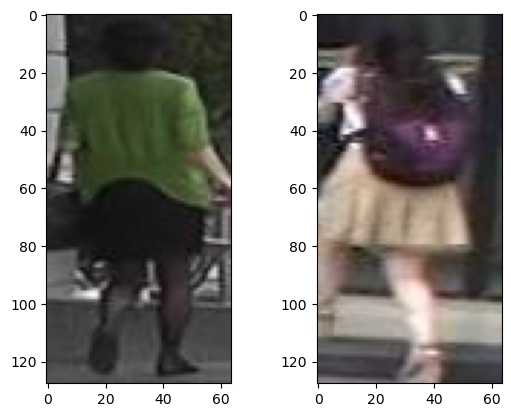

In [230]:
for j in range(4):
  plt.figure()
  f,ax=plt.subplots(1,2)
  ax[0].imshow(market_triplet[j][0])
  ax[1].imshow(market_triplet[j][1])
  plt.pause(0.1)

<Figure size 640x480 with 0 Axes>

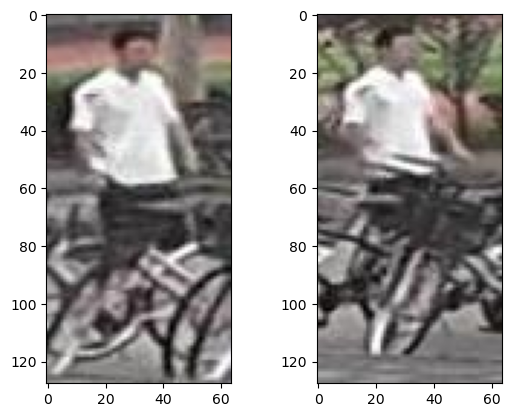

<Figure size 640x480 with 0 Axes>

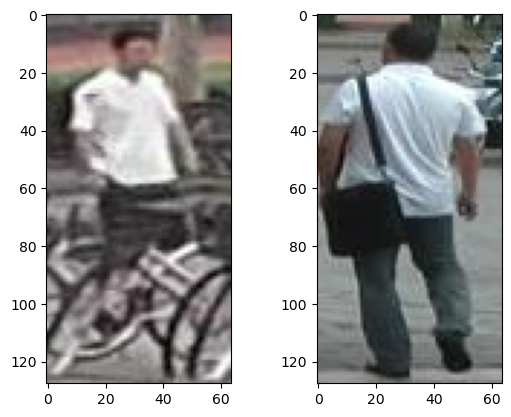

<Figure size 640x480 with 0 Axes>

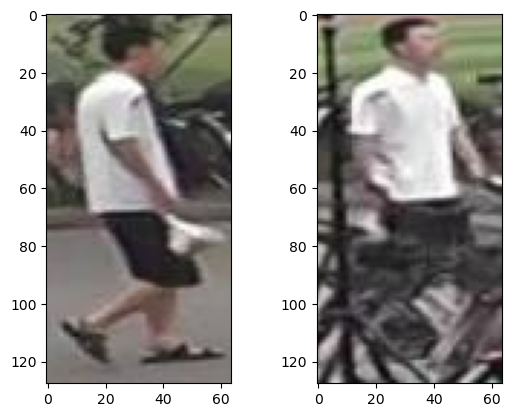

<Figure size 640x480 with 0 Axes>

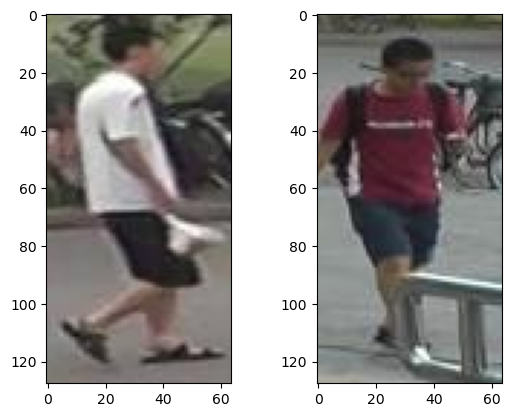

<Figure size 640x480 with 0 Axes>

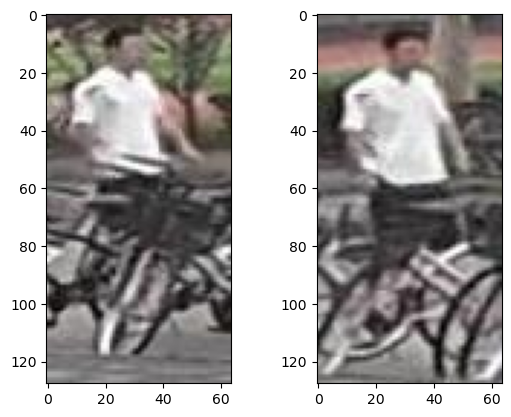

<Figure size 640x480 with 0 Axes>

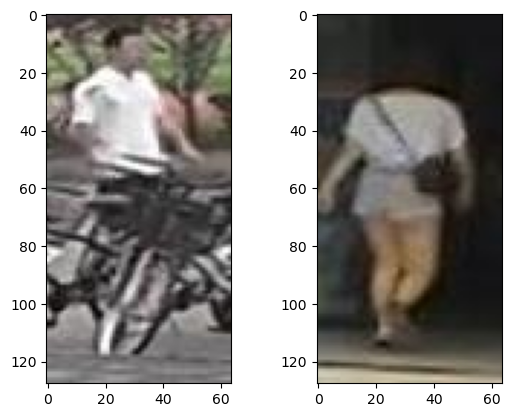

In [231]:
for j in range(6):
  plt.figure()
  f,ax=plt.subplots(1,2)
  ax[0].imshow(val_data[j][0])
  ax[1].imshow(val_data[j][1])
  plt.pause(0.1)

# Creating the network and Training it

In [232]:
from torch import nn,optim
class Siamese_net(nn.Module):
  def __init__(self):
    super(Siamese_net, self).__init__()
    resnet = models.resnet34(pretrained=True)
    resnet.fc=nn.Linear(resnet.fc.in_features,256)
    nn.init.xavier_uniform_(resnet.fc.weight)
    self.resnet=resnet
  def forward(self, x1,x2):
    return self.resnet(x1),self.resnet(x2)
  def freeze(self):
    for p in self.resnet.parameters():
        p.requires_grad=False
    for p in self.resnet.fc.parameters():
        p.requires_grad=True
    for p in self.resnet.layer4.parameters():
        p.requires_grad=True
    print('layer freezed')
  def unfreeze(self):
    for p in self.resnet.parameters():
        p.requires_grad=True
    print('layer unfreezed')
  def embed(self, x):
    return self.resnet(x)

In [233]:
def get_cost_function():
  cost_function = torch.nn.CosineEmbeddingLoss()
  return cost_function

def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
  return optimizer

In [234]:
def train(net,train_data_loader,val_data_loader,optimizer,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.

  
  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (anchors, positives,labels) in enumerate(train_data_loader):
    # Load data into GPU
    anchors = anchors.to(device)
    positives = positives.to(device)
    labels=labels.to(device)
    # Forward pass
    anchors_out,positives_out = net(anchors,positives)
    # Apply the loss
    loss = cost_function(anchors_out,positives_out,labels)
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()
    # Reset the optimizer
    optimizer.zero_grad()

    # Better print something, no?
    samples+=anchors.shape[0]
    cumulative_loss += loss.item()*anchors.shape[0]
  return cumulative_loss/samples

In [235]:
def evaluate(net,data_loader,cost_function, device='cuda:0'):
  samples = 0.
  cumulative_loss = 0.

  
  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (anchors, positives,labels) in enumerate(data_loader):
    # Load data into GPU
    anchors = anchors.to(device)
    positives = positives.to(device)
    labels=labels.to(device)
    # Forward pass
    anchors_out,positives_out = net(anchors,positives)
    # Apply the loss
    loss = cost_function(anchors_out,positives_out,labels)

    samples+=anchors.shape[0]
    cumulative_loss += loss.item()*anchors.shape[0]
  return cumulative_loss/samples

In [236]:
def get_data(batch_size,l,root_dir,shuff=True):

    # Prepare data transformations and then combine them sequentially
    transform = list()
    transform.append(T.ToTensor())
    transform.append(T.Resize((224,224)))                           # converts Numpy to Pytorch Tensor
    transform.append(T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]))      # Normalizes the Tensors between [-1, 1]
    transform = T.Compose(transform)
    full_training_data = MyDataset(l,root_dir, transform=transform)
    train_loader = torch.utils.data.DataLoader(full_training_data, batch_size, shuffle=shuff, num_workers=1)
    return train_loader

In [237]:
batch_size=64
device='cuda:0' 
learning_rate=0.0005
weight_decay=0.000001 
momentum=0.9
epochs=6
train_loader = get_data(batch_size,train_l,root_dir)
val_loader=get_data(batch_size,val_l,root_dir)
net = Siamese_net().to(device)
net.freeze()
optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
cost_function = get_cost_function()

layer freezed


In [238]:
print('start training')
for e in range(epochs):
    if e ==2 :
      net.unfreeze()
    train_loss = train(net, train_loader,val_loader, optimizer, cost_function)
    val_loss=evaluate(net,val_loader,cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('train loss= %.2f val loss= %.2f '%(train_loss,val_loss))

start training
Epoch: 1
train loss= 0.17 val loss= 0.17 
Epoch: 2
train loss= 0.11 val loss= 0.16 
layer unfreezed
Epoch: 3
train loss= 0.13 val loss= 0.14 
Epoch: 4
train loss= 0.11 val loss= 0.14 
Epoch: 5
train loss= 0.09 val loss= 0.14 
Epoch: 6
train loss= 0.08 val loss= 0.13 


In [239]:
#torch.save(net.state_dict(), "/content/drive/MyDrive/projet deep learning/person_reid_model_1")

# Evaluating the peroformance of the model

In [243]:
transform = list()
transform.append(T.ToTensor())
transform.append(T.Resize((224,224)))                             # converts Numpy to Pytorch Tensor
transform.append(T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]))      # Normalizes the Tensors between [-1, 1]
transform = T.Compose(transform)
query_dataset=custom_val(query_list,root_dir,transform)
val_dataset=custom_val(val_list,root_dir,transform)

def image_embed(dataset,net,device):
  data_loader = torch.utils.data.DataLoader(dataset, 1, shuffle=False, num_workers=1)
  img_embd_arr=np.zeros( ( len(dataset) , 256) )
  net.eval()
  with torch.no_grad():
    for batch_idx ,img in enumerate(data_loader):
      input=img.to(device)
      img_embd=net.embed(input)
      img_embd=img_embd.cpu().detach().numpy()
      img_embd_arr[batch_idx]=img_embd
      if (batch_idx % 256 ==0) :
        print(batch_idx)
  return torch.tensor(img_embd_arr)

In [248]:
def predict(query_data,test_data,net,device):
  img_embd_query=image_embed(query_data,net,device)
  print('query_embedding_finished')
  img_embd_test=image_embed(test_data,net,device)
  print('test_embedding_finished')
  test_list=test_data.l
  query_list=query_data.l
  cos=torch.nn.CosineSimilarity(dim=0)
  d={ key:[] for key in query_list }
  for i in range( len(test_list) ):
    for j in range( len(query_list) ):
      if cos(img_embd_query[j],img_embd_test[i]) >0.85 :
        d[ query_list[j] ].append(test_list[i])
  return d,img_embd_query,img_embd_test

In [249]:
d_pred,img_embd_query,img_embd_test=predict(query_dataset,val_dataset,net,device)

0
query_embedding_finished
0
256
test_embedding_finished


In [250]:
from typing import Dict, Set, List
def evaluate_map(predictions: Dict[str, List], ground_truth: Dict[str, Set]):
        '''
        Computes the mAP (https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173) of the predictions with respect to the given ground truth
        In person reidentification mAP refers to the mean of the AP over all queries.
        The AP for a query is the area under the precision-recall curve obtained from the list of predictions considering the
        ground truth elements as positives and the other ones as negatives

        :param predictions: dictionary from query filename to list of test image filenames associated with the query ordered
                            from the most to the least confident prediction.
                            Represents the predictions to be evaluated.
        :param ground_truth: dictionary from query filename to set of test image filenames associated with the query
                             Represents the ground truth on which to evaluate predictions.

        :return:
        '''

        m_ap = 0.0
        for current_ground_truth_query, current_ground_truth_query_set in ground_truth.items():

            # No predictions were performed for the current query, AP = 0
            if not current_ground_truth_query in predictions:
                continue

            current_ap = 0.0  # The area under the curve for the current sample
            current_predictions_list = predictions[current_ground_truth_query]

            # Recall increments of this quantity each time a new correct prediction is encountered in the prediction list
            delta_recall = 1.0 / len(current_ground_truth_query_set)

            # Goes through the list of predictions
            encountered_positives = 0
            for idx, current_prediction in enumerate(current_predictions_list):
                # Each time a positive is encountered, compute the current precition and the area under the curve
                # since the last positive
                if current_prediction in current_ground_truth_query_set:
                    encountered_positives += 1
                    current_precision = encountered_positives / (idx + 1)
                    current_ap += current_precision * delta_recall

            m_ap += current_ap

        # Compute mean over all queries
        m_ap /= len(ground_truth)

        return m_ap

In [251]:
evaluate_map(d_pred,d_truth)*100

24.233406222053286